#Homework 2: kNN classification

####1. Implement KNN classification, using the sklearn package.

In [193]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [194]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

iris = load_iris()
clf = KNeighborsClassifier(10)
data_train, data_test, target_train, target_test = train_test_split(iris.data, iris.target, 
                                                                    test_size = 0.4, random_state = 42)
clf.fit(data_train, target_train)
score = clf.score(data_test, target_test)
print score

0.983333333333


####2. Use the sklearn package to implement cross-validation for your classifier. Use 5 folds for your cross-validation.

In [196]:
import sklearn.cross_validation as cv

kfold = cv.KFold(len(iris.target), n_folds = 5)
scores = []
for train, test in kfold:
    data_train, target_train = iris.data[train], iris.target[train]
    data_test, target_test = iris.data[test], iris.target[test]
    clf.fit(data_train, target_train)
    score = clf.score(data_test, target_test)
    scores.append(score)

print scores
print np.mean(scores)

[1.0, 1.0, 0.8666666666666667, 0.96666666666666667, 0.76666666666666672]
0.92


Since the data is ordered this may lead to imbalence in the taret category representation in the kfold crossvalidation. To see how this affects the results I tried the same kNN prediction with the `StratifiedKFold` function, which preserves class representation in the training and test sets.

In [197]:
skfold = cv.StratifiedKFold(iris.target, n_folds = 5)
scores = []
for train, test in skfold:
    data_train, target_train = iris.data[train], iris.target[train]
    data_test, target_test = iris.data[test], iris.target[test]
    clf.fit(data_train, target_train)
    score = clf.score(data_test, target_test)
    scores.append(score)

print scores
print np.mean(scores)

[0.96666666666666667, 1.0, 1.0, 0.93333333333333335, 1.0]
0.98


The `StratifiedKFold` algorithm seems to lead to better overall scores than the normal `KFold` algorithm.

####3. Use your KNN classifier and cross-validation code from (1) and (2) above to determine the optimal value of K (number of nearest neighbors to consult) for this Iris dataset.

In [213]:
n_folds = 5
kfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
#kfold = cv.KFold(len(iris.data), n_folds = n_folds, shuffle = False)
max_k = int((n_folds-1)*(len(iris.target)//n_folds))
optimal_k = 0
best_score = 0
for k in xrange(1,max_k+1):
    clf = KNeighborsClassifier(k)
    scores = []
    for train, test in kfold:
        data_train, target_train = iris.data[train], iris.target[train]
        data_test, target_test = iris.data[test], iris.target[test]
        clf.fit(data_train, target_train)
        score = clf.score(data_test, target_test)
        scores.append(score)
    if np.mean(scores) >= best_score:
        best_score = np.mean(scores)
        optimal_k = k

print optimal_k, best_score

12 0.98


####4. Using matplotlib, plot classifier accuracy versus the hyperparameter K for a range of K that you consider interesting. Explain in words what you are seeing.

1 loops, best of 3: 664 ms per loop


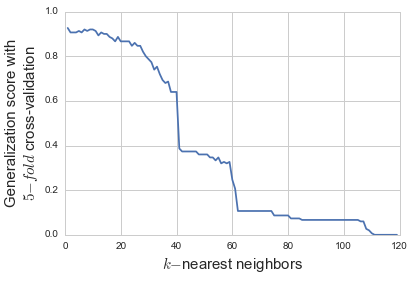

In [231]:
%%timeit
plt.hold(False)
n_folds = 5
#skfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
kfold = cv.KFold(len(iris.data), n_folds = n_folds, shuffle = False)
max_k = int((n_folds-1)*(len(iris.target)//n_folds))
mean_scores = []
ks = range(1,max_k)
for k in ks:
    clf = KNeighborsClassifier(k)
    scores = []
    for train, test in kfold:
        data_train, target_train = iris.data[train], iris.target[train]
        data_test, target_test = iris.data[test], iris.target[test]
        clf.fit(data_train, target_train)
        score = clf.score(data_test, target_test)
        scores.append(score)
    mean_scores.append(np.mean(scores))

sns.set_style('whitegrid')
sns.plt.plot(ks,mean_scores)
sns.plt.xlabel('$k-$nearest neighbors', size = 15)
sns.plt.ylabel('Generalization score with\n$5-fold$ cross-validation', size = 15)

It looks like there are two large drops in accuracy when using the standard KFold crossvalidation algorithm. These seem to correspond to points where the number of neighbors consulted is greater than the remaining number of class members for the majority of the test points. Because the standard KFold algorithm partitions data according to its order there is a large imbalance in the number of same-class neighbors that depends on the number of folds. With 5-fold crossvalidation, 3 classes, and 150 ordered data points, the smallest possible number of classes in the training set will be 20. Therefore, when scoring based on votes from more than 40 of the nearest neighbors you will always be wrong since the majority of neighbors will never be in the correct class. Similarly, the largest number of same-class neighbors for a given test set will be thirty. Therefore voting the same problem applies to voting from the nearest 60 neighbors. The worst case scenario would be 3-partitioning with 3 ordered equally represented classes. This would leave no same-class neighbors for each round of crossvalidation:

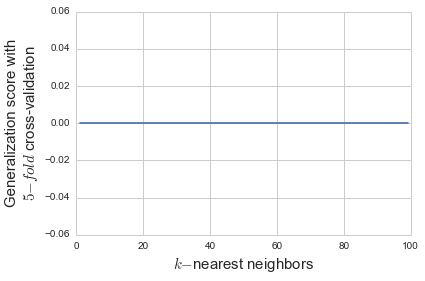

In [236]:
plt.hold(False)
n_folds = 3
#skfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
kfold = cv.KFold(len(iris.data), n_folds = n_folds, shuffle = False)
max_k = int((n_folds-1)*(len(iris.target)//n_folds))
mean_scores = []
ks = range(1,max_k)
for k in ks:
    clf = KNeighborsClassifier(k)
    scores = []
    for train, test in kfold:
        data_train, target_train = iris.data[train], iris.target[train]
        data_test, target_test = iris.data[test], iris.target[test]
        clf.fit(data_train, target_train)
        score = clf.score(data_test, target_test)
        scores.append(score)
    mean_scores.append(np.mean(scores))

sns.set_style('whitegrid')
sns.plt.plot(ks,mean_scores)
sns.plt.xlabel('$k-$nearest neighbors', size = 15)
sns.plt.ylabel('Generalization score with\n$5-fold$ cross-validation', size = 15)

####5. Now, write your own implementation of cross-validation in Python without using the cross-validation methods from sklearn.

In [237]:
def KFold_cv(x, n_folds = 3):
    '''Implementation of K-fold data partitioning for use in cross-validation.'''
    if not (type(x) == int and type(n_folds) == int):
        raise TypeError('Arguments must be integers')
    if n_folds > x:
        raise Exception('Too many folds for size of input data')
    indices = range(x)
    partition = int(x//n_folds)
    for p in xrange(n_folds):
        test = indices[p*partition:(p+1)*partition]
        train = list(set(indices).difference(set(test)))
        yield (train, test)

1 loops, best of 3: 692 ms per loop


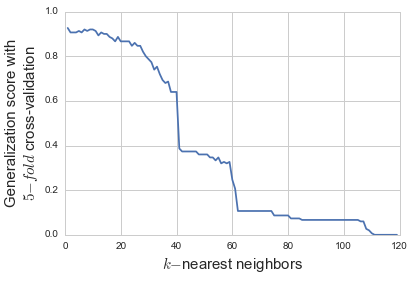

In [238]:
%%timeit
plt.hold(False)
n_folds = 5
#skfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
#kfold = cv.KFold(len(iris.data), n_folds = n_folds)
mean_scores = []
ks = range(1,int(len(iris.target)*(n_folds-1)/n_folds))
for k in ks:
    clf = KNeighborsClassifier(k)
    kfold = KFold_cv(len(iris.data), n_folds = n_folds)
    scores = []
    for train, test in kfold:
        data_train, target_train = iris.data[train], iris.target[train]
        data_test, target_test = iris.data[test], iris.target[test]
        clf.fit(data_train, target_train)
        score = clf.score(data_test, target_test)
        scores.append(score)
    mean_scores.append(np.mean(scores))

sns.set_style('whitegrid')
sns.plt.plot(ks,mean_scores)
sns.plt.xlabel('$k-$nearest neighbors', size = 15)
sns.plt.ylabel('Generalization score with\n$5-fold$ cross-validation', size = 15)

####6. EXTRA CREDIT 1: Using the value of K obtained in (3) above, vary the number of folds used for cross-validation across an interesting range, e.g. [ 2, 3, 5, 6, 10, 15]. How does classifier accuracy vary with the number of folds used? Do you think there exists an optimal number of folds to use for this particular problem? Why or why not?

<function axes at 0x10e196050>


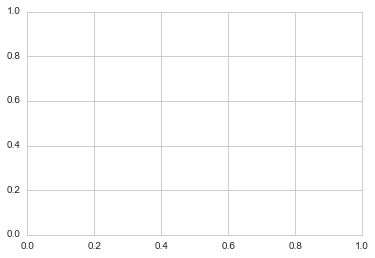

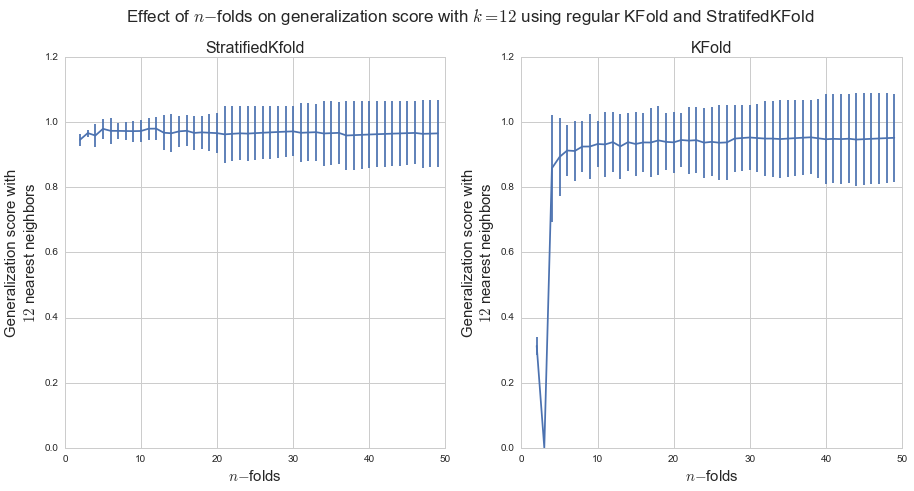

In [283]:
plt.hold(False)
k = 12
sk_mean_scores = []
sk_stds = []
k_mean_scores = []
k_stds = []
max_folds_for_skfold = int(len(iris.target)//len(set(iris.target)))
max_folds_for_kfold = len(iris.target)
X = xrange(2,max_folds_for_skfold)
clf = KNeighborsClassifier(k)
for n_folds in X:
    kfold = cv.KFold(len(iris.data), n_folds = n_folds)
    skfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
    sk_scores = []
    k_scores = []
    for (sk_train, sk_test),(k_train, k_test) in zip(skfold,kfold):
        sk_data_train, sk_target_train = iris.data[sk_train], iris.target[sk_train]
        sk_data_test, sk_target_test = iris.data[sk_test], iris.target[sk_test]
        k_data_train, k_target_train = iris.data[k_train], iris.target[k_train]
        k_data_test, k_target_test = iris.data[k_test], iris.target[k_test]
        clf.fit(sk_data_train, sk_target_train)
        score = clf.score(sk_data_test, sk_target_test)
        sk_scores.append(score)
        clf.fit(k_data_train, k_target_train)
        score = clf.score(k_data_test, k_target_test)
        k_scores.append(score)
    sk_mean_scores.append(np.mean(sk_scores))
    sk_stds.append(np.std(sk_scores, ddof = 1))
    k_mean_scores.append(np.mean(k_scores))
    k_stds.append(np.std(k_scores, ddof = 1))

fig, (skf, kf) = sns.plt.subplots(1,2, sharey = True, figsize = (15,7))
sns.set_style('whitegrid')
skf.errorbar(X,sk_mean_scores,yerr = sk_stds)
kf.errorbar(X,k_mean_scores, yerr = k_stds)
skf.set_xlabel('$n-$folds', size = 15)
kf.set_xlabel('$n-$folds', size = 15)
skf.set_ylabel('Generalization score with\n${}$ nearest neighbors'.format(k), size = 15)
kf.set_ylabel('Generalization score with\n${}$ nearest neighbors'.format(k), size = 15)
skf.set_title('StratifiedKfold', size = 16)
kf.set_title('KFold', size = 16)
fig.suptitle('Effect of $n-$folds on generalization score with $k={}$ \
using regular KFold and StratifedKFold'.format(k), size = 17, y = 1.0)
print sns.plt.axes


As the number of folds increases there is an increase in the average score. There is probably no optimal number of folds for any $k$, but depending on the $k$ there will be folds that are not suitable. For instance, it is clear on the KFold plot that using 3 folds leads to 0% accuracy as described for question 4. Using the StratifiedKFold algorithm the number of folds is less important since the representation of the classes will be normalized across the folds. While there may be a maximum achievable *accuracy* for this dataset, the *bias* will probably be higher for larger numbers of folds as the neighbors "seen" for any given test point will be more affected by the training set.

In [288]:
ks = range(0,len(iris.target))
folds = range(1,len(iris.target))
xx, yy = np.meshgrid(folds, ks, indexing = 'xy')
zz = np.ma.zeros(xx.size)
combos = np.c_[xx.ravel(), yy.ravel()]
best_score = 0
best_k = 0
best_fold = 0
all_scores = []

n = 0
for idx, (fold, k) in enumerate(combos):
    small_partition = (len(iris.target)//fold)
    if ((fold-1)*small_partition > k) & (small_partition > 2) & (fold > 1) & (k > 0):
        kfold = cv.KFold(len(iris.target), fold)
        clf = KNeighborsClassifier(k)
        scores = []
        for train, test in kfold:
            data_train, target_train = iris.data[train], iris.target[train]
            data_test, target_test = iris.data[test], iris.target[test]
            clf.fit(data_train, target_train)
            score = clf.score(data_test, target_test)
            scores.append(score)
        mean_score = np.mean(scores)
        zz[idx] = mean_score
        all_scores.append(mean_score)
        if mean_score >= best_score:
            #print idx, n, fold, k
            best_k = k
            best_fold = fold
            best_score = mean_score
    else:
        zz[idx] = np.ma.masked_singleton
        all_scores.append(0.0)
    n += 1

print n    
zz = zz.reshape(xx.shape)

22350


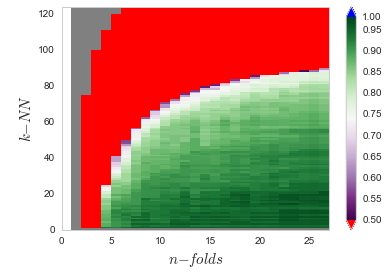

In [290]:
cmap = plt.cm.PRGn
cmap.set_bad('grey', 1)
cmap.set_under('red', 1)
cmap.set_over('blue', 1)
sns.plt.pcolormesh(xx, yy, zz, vmin = 0.5, cmap = cmap)
sns.plt.colorbar(extend = 'both')
sns.plt.xlabel('$n-folds$', size = 15)
sns.plt.ylabel('$k-NN$', size = 15)
sns.plt.xlim(xmax = 27)
sns.plt.ylim(ymax = 124)
sns.plt.annotate('$Best$ $k$ , $n-fold$: ${}$ , ${}$ $({:.4f})$'.format(best_k,best_fold,best_score), 
                 xy = (best_fold, best_k), xytext = (6,100), size = 18, color = 'white',
                 arrowprops=dict(arrowstyle = '-|>', lw = 1.3, shrinkB = 0, color = 'white'))

####7. EXTRA CREDIT 2: Write your own implementation of KNN classification in Python, without using the methods from sklearn. Compare your results with the results you obtained using sklearn.

In [293]:
class KNN(object):
    "My implementation of the K-nearest neighbor algorithm"
    def __init__(self, k):
        self.k = k
        
    def fit(self, train_features, train_targets):
        self.train_features = train_features
        self.train_targets = train_targets
        
    def predict(self, features):
        import collections
        targets = []
        for f in features:
            sub = self.train_features - f
            sub = sub**2
            sub = np.sum(sub, axis = 1)
            sub = sub**.5
            topk_indices = np.argsort(sub)[:self.k]
            vote = collections.Counter(self.train_targets.take(topk_indices))
            targets.append(vote.most_common(1)[0][0])
        return np.array(targets)
    
    def score(self, test_features, test_targets):
        results = self.predict(test_features)
        score = (results == test_targets)
        return np.mean(score)

1 loops, best of 3: 1.64 s per loop


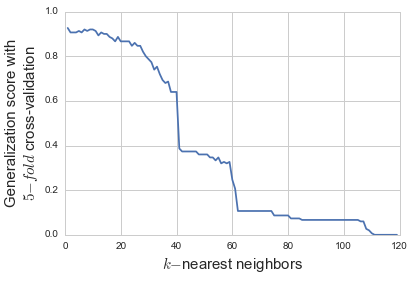

In [301]:
%%timeit
plt.hold(False)
n_folds = 5
#skfold = cv.StratifiedKFold(iris.target, n_folds = n_folds)
#kfold = cv.KFold(len(iris.data), n_folds = n_folds)
mean_scores = []
ks = range(1,int(len(iris.target)*(n_folds-1)/n_folds))
for k in ks:
    clf = KNN(k)
    kfold = KFold_cv(len(iris.data), n_folds = n_folds)
    scores = []
    for train, test in kfold:
        data_train, target_train = iris.data[train], iris.target[train]
        data_test, target_test = iris.data[test], iris.target[test]
        clf.fit(data_train, target_train)
        score = clf.score(data_test, target_test)
        scores.append(score)
    mean_scores.append(np.mean(scores))

sns.set_style('whitegrid')
sns.plt.plot(ks,mean_scores)
sns.plt.xlabel('$k-$nearest neighbors', size = 15)
sns.plt.ylabel('Generalization score with\n$5-fold$ cross-validation', size = 15)

Slow but gets the job done.